In [1]:
import os
import sys
from datetime import date
from tme_utils import (
    EventTypes,
    get_client,
    query_blocks,
    query_events,
    query_receipt,
    query_state
)

%load_ext google.cloud.bigquery
from google.cloud import bigquery

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 5]

In [2]:
project = "celo-testnet"
dataset = "tme_test_stakeoff"
partition = "*"
table = "tme_stakeoff_test_{0}".format(partition)
# dataset = "transaction_metrics_exporter"
# partition = date.today().strftime("%Y%m%d")
# table = "transaction_metrics_exporter_{0}".format(partition)

window_min = 64000
window_max = 70000

client = get_client(project)

tme = client.get_dataset(dataset)
table_path = ".".join([project, dataset, table])
print(table_path)

celo-testnet.tme_test_stakeoff.tme_stakeoff_test_*


In [3]:
df_blocks = query_blocks(client, table_path, window_min, window_max)
df_receipt = query_receipt(client, table_path, window_min, window_max)
df_state = query_state(client, table_path, window_min, window_max, df_blocks)
df_events = query_events(client, table_path, window_min, window_max, df_state)
df_blocks.describe()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
count,5.949000e+03,5949.000000,5.949000e+03,5949.0,5949.000000,5948.000000
mean,1.579034e+09,66993.570348,5.170440e+05,20000000.0,1.050261,5.135508
std,8.824941e+03,1734.163545,1.915500e+05,0.0,0.329550,1.224901
min,1.579019e+09,64000.000000,0.000000e+00,20000000.0,1.000000,5.000000
25%,1.579026e+09,65489.000000,3.905950e+05,20000000.0,1.000000,5.000000
50%,1.579034e+09,66989.000000,5.110270e+05,20000000.0,1.000000,5.000000
75%,1.579042e+09,68498.000000,6.196890e+05,20000000.0,1.000000,5.000000
max,1.579049e+09,70000.000000,2.784165e+06,20000000.0,4.000000,30.000000


In [4]:
query_balance = f"""
SELECT 
    jsonPayload.blockNumber,
    jsonPayload.values.balance,
    jsonPayload.contract,
    jsonPayload.function,
    jsonPayload.args
FROM `celo-testnet.tme_test_stakeoff.transaction_metrics_exporter_20200401` 
WHERE 
    jsonPayload.function="balanceOf" and
    jsonPayload.event='{EventTypes.RECEIVED_STATE.value}' and
    jsonPayload.blockNumber >= {window_min} and
    jsonPayload.blockNumber <= {window_max}
ORDER BY 
    jsonPayload.blockNumber DESC
"""

df_balance = client.query(
    query_balance,
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()


In [5]:
df_balance.head()

,blockNumber,balance,contract,function,args


In [6]:
df_blocks.head()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
0,1.579049e+09,70000.0,542851.0,20000000.0,4,5.0
1,1.579049e+09,69999.0,331148.0,20000000.0,1,5.0
2,1.579049e+09,69998.0,240864.0,20000000.0,1,5.0
3,1.579049e+09,69997.0,340595.0,20000000.0,1,5.0
4,1.579049e+09,69996.0,311232.0,20000000.0,1,5.0


last block  : 70000 on 1579049346.0
first block : 64000 on 1579018800.0
blocks load : 5949
transactions: 6248
mean gasUsed: 517044 GcWei
mean blocktime: 5.1 s


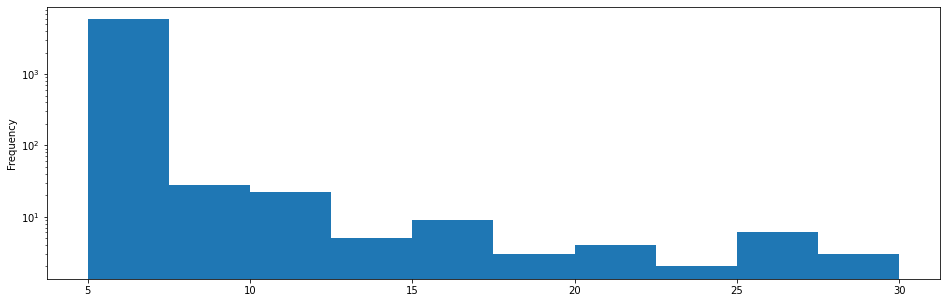

In [7]:
last_block, first_block = df_blocks.blockNumber.max(), df_blocks.blockNumber.min()
print(f"last block  : {last_block:.0f} on {df_blocks.timestamp.max()}") 
print(f"first block : {first_block:.0f} on {df_blocks.timestamp.min()}")
print(f"blocks load : {df_blocks.timestamp.count():.0f}")
print(f"transactions: {df_blocks.txAmount.sum()}")
print(f"mean gasUsed: {df_blocks.gasUsed.mean():.0f} GcWei")
df_blocks.blocktime.plot.hist(logy=True)
print(f"mean blocktime: {df_blocks.blocktime.mean():.1f} s")

In [8]:
df_state.describe()

,blockNumber,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime
count,5949.000000,5.944000e+03,5.940000e+03,5942.000000,5.944000e+03,5.944000e+03,5.941000e+03,5.949000e+03,5.949000e+03,5949.0,5949.000000,5948.000000
mean,66993.570348,6.001421e+26,1.616688e+24,0.996866,9.925529e+23,9.953795e+23,1.069456e+26,1.579034e+09,5.170440e+05,20000000.0,1.050261,5.135508
std,1734.163545,3.730760e+21,2.980131e+19,0.000413,5.905999e+20,2.667548e+20,3.190852e+22,8.824941e+03,1.915500e+05,0.0,0.329550,1.224901
min,64000.000000,6.001357e+26,1.616618e+24,0.996000,9.913667e+23,9.935842e+23,1.069011e+26,1.579019e+09,0.000000e+00,20000000.0,1.000000,5.000000
25%,65489.000000,6.001389e+26,1.616660e+24,0.997000,9.924714e+23,9.953156e+23,1.069126e+26,1.579026e+09,3.905950e+05,20000000.0,1.000000,5.000000
50%,66989.000000,6.001421e+26,1.616690e+24,0.997000,9.925815e+23,9.954207e+23,1.069466e+26,1.579034e+09,5.110270e+05,20000000.0,1.000000,5.000000
75%,68498.000000,6.001454e+26,1.616716e+24,0.997000,9.928025e+23,9.955562e+23,1.069777e+26,1.579042e+09,6.196890e+05,20000000.0,1.000000,5.000000
max,70000.000000,6.001486e+26,1.616727e+24,0.998000,9.947931e+23,9.957558e+23,1.070151e+26,1.579049e+09,2.784165e+06,20000000.0,4.000000,30.000000


In [9]:
df_state.tail()

,blockNumber,timestamp_tme,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime,datetime_block
5944,69996.0,2020-03-25 20:16:49.369296+00:00,6.001486e+26,1.616619e+24,0.997,9.931696e+23,9.953439e+23,1.070151e+26,1.579049e+09,311232.0,20000000.0,1,5.0,2020-01-15 00:48:46
5945,69997.0,2020-03-25 20:16:50.533510+00:00,6.001486e+26,1.616619e+24,0.997,9.931696e+23,9.953439e+23,1.070151e+26,1.579049e+09,340595.0,20000000.0,1,5.0,2020-01-15 00:48:51
5946,69998.0,2020-03-25 20:16:51.837895+00:00,6.001486e+26,1.616619e+24,0.997,9.931696e+23,9.953439e+23,1.070151e+26,1.579049e+09,240864.0,20000000.0,1,5.0,2020-01-15 00:48:56
5947,69999.0,2020-03-25 20:16:52.709508+00:00,6.001486e+26,1.616619e+24,0.997,9.927586e+23,9.957459e+23,1.070151e+26,1.579049e+09,331148.0,20000000.0,1,5.0,2020-01-15 00:49:01
5948,70000.0,2020-03-25 20:16:53.874539+00:00,6.001486e+26,1.616619e+24,0.997,9.929621e+23,9.955428e+23,1.070151e+26,1.579049e+09,542851.0,20000000.0,4,5.0,2020-01-15 00:49:06


Text(0, 0.5, 'SortedOracles.medianRate')

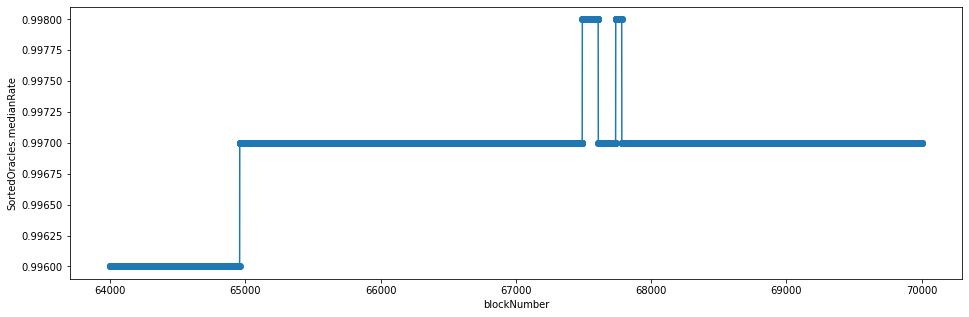

In [10]:
df_slice = df_state[1:]
df_sortedOracles = df_slice.set_index('blockNumber')['medianRate']
ax = df_sortedOracles.plot(marker='o')
ax.set_ylabel("SortedOracles.medianRate")

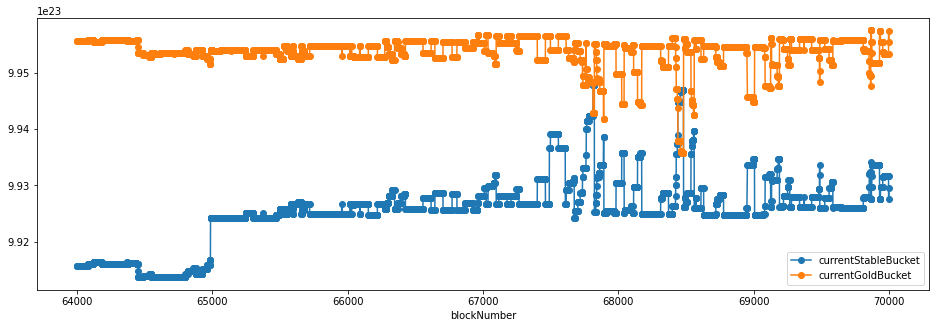

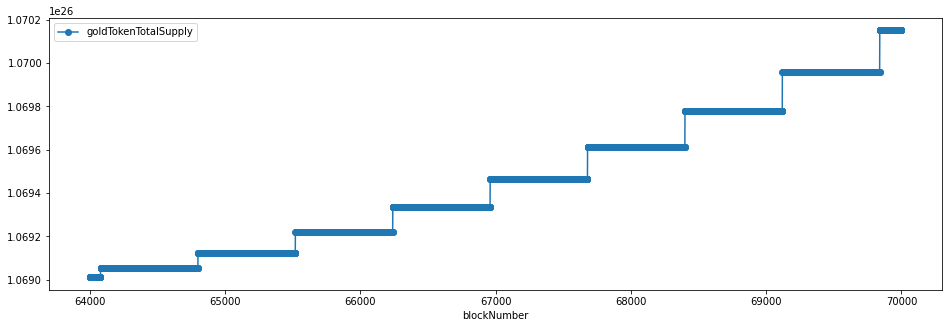

In [11]:
df_stableToken = df_state.set_index('blockNumber')[['currentStableBucket']]
ax = df_stableToken.plot(marker='o')
# df_stableToken[df_stableToken<2e24].plot(marker='o')
df_goldbucket = df_state.set_index('blockNumber')[['currentGoldBucket']]
df_goldbucket.plot(marker='o', ax=ax)
df_goldToken = df_state.set_index('blockNumber')[['goldTokenTotalSupply']]
df_goldToken.plot(marker='o')

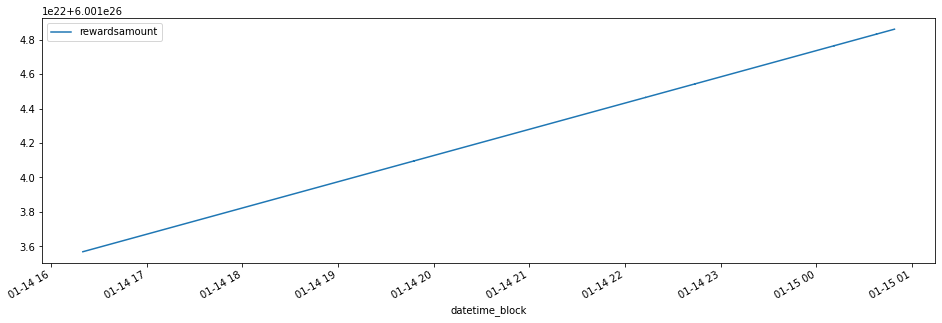

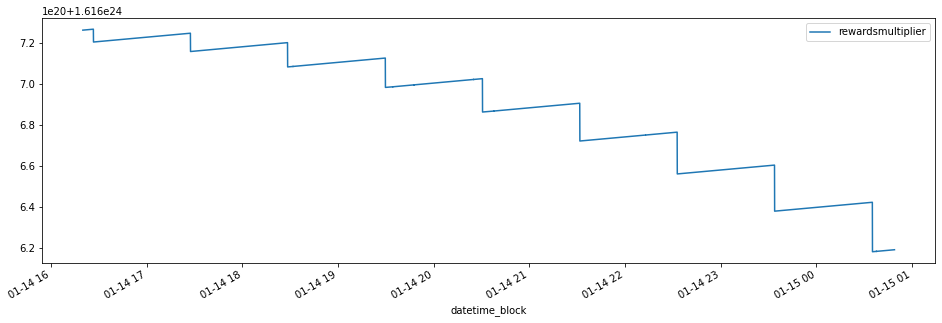

In [12]:
df_rewardsAmount = df_state.set_index('datetime_block')[['rewardsamount']]
ax = df_rewardsAmount.plot()
df_rewardsMultiplier = df_state.set_index('datetime_block')[['rewardsmultiplier']]
ax = df_rewardsMultiplier.plot()

In [13]:
df_events.describe()

,blockNumber,sellamount,buyamount,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime
count,52679.000000,1.770000e+02,1.770000e+02,5.265000e+04,5.261800e+04,52644.000000,5.265500e+04,5.265500e+04,5.262800e+04,5.267900e+04,5.267900e+04,52679.0,52679.000000,52643.000000
mean,66743.527971,1.310357e+20,1.306511e+20,6.001416e+26,1.616692e+24,0.996834,9.925030e+23,9.953786e+23,1.069410e+26,1.579033e+09,5.728247e+05,20000000.0,1.160614,5.254792
std,1708.329123,1.342446e+20,1.337858e+20,3.674988e+21,2.855239e+19,0.000436,6.102799e+20,2.620552e+20,3.078105e+22,8.693246e+03,2.353527e+05,0.0,0.616940,1.844994
min,64000.000000,0.000000e+00,0.000000e+00,6.001357e+26,1.616618e+24,0.996000,9.913667e+23,9.935842e+23,1.069011e+26,1.579019e+09,2.936300e+04,20000000.0,1.000000,5.000000
25%,65247.000000,2.034908e+19,2.028269e+19,6.001384e+26,1.616673e+24,0.997000,9.924155e+23,9.953156e+23,1.069126e+26,1.579025e+09,4.405950e+05,20000000.0,1.000000,5.000000
50%,66613.000000,1.000000e+20,9.973352e+19,6.001413e+26,1.616700e+24,0.997000,9.925705e+23,9.954094e+23,1.069336e+26,1.579032e+09,5.493210e+05,20000000.0,1.000000,5.000000
75%,68210.000000,1.733065e+20,1.729288e+20,6.001447e+26,1.616717e+24,0.997000,9.927798e+23,9.955533e+23,1.069614e+26,1.579040e+09,6.520960e+05,20000000.0,1.000000,5.000000
max,70000.000000,6.890483e+20,6.868562e+20,6.001486e+26,1.616727e+24,0.998000,9.947931e+23,9.957558e+23,1.070151e+26,1.579049e+09,2.784165e+06,20000000.0,4.000000,30.000000


In [14]:
df_events.head()

,blockNumber,address,eventName,identifier,addr,identifierhash,slasheridentifier,account,metadataurl,value,...,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime,datetime_block
0,70000.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.997,9.929621e+23,9.955428e+23,1.070151e+26,1.579049e+09,542851.0,20000000.0,4,5.0,2020-01-15 00:49:06
1,70000.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,203490000000000000000,...,0.997,9.929621e+23,9.955428e+23,1.070151e+26,1.579049e+09,542851.0,20000000.0,4,5.0,2020-01-15 00:49:06
2,70000.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.997,9.929621e+23,9.955428e+23,1.070151e+26,1.579049e+09,542851.0,20000000.0,4,5.0,2020-01-15 00:49:06
3,70000.0,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,Transfer,None,None,None,None,None,None,10000,...,0.997,9.929621e+23,9.955428e+23,1.070151e+26,1.579049e+09,542851.0,20000000.0,4,5.0,2020-01-15 00:49:06
4,70000.0,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,Transfer,None,None,None,None,None,None,10000,...,0.997,9.929621e+23,9.955428e+23,1.070151e+26,1.579049e+09,542851.0,20000000.0,4,5.0,2020-01-15 00:49:06


In [15]:
df_events.groupby('eventName').eventName.count().sort_values(ascending=False)

eventName
Transfer                          51562
Approval                            258
Exchanged                           177
GoldLocked                          169
ValidatorGroupVoteCast              165
ValidatorGroupVoteActivated         118
AttestationsRequested                44
AttestationIssuerSelected            40
AccountMetadataURLSet                34
AttestationCompleted                 19
AccountCreated                       11
AccountNameSet                       10
ValidatorAffiliated                   9
ValidatorGroupMarkedEligible          9
ValidatorGroupMemberAdded             9
ValidatorGroupMarkedIneligible        7
ValidatorGroupMemberRemoved           7
ValidatorRegistered                   5
AttestationSignerAuthorized           5
ValidatorGroupRegistered              5
AccountDataEncryptionKeySet           5
ValidatorSignerAuthorized             5
ValidatorDeaffiliated                 4
GoldWithdrawn                         1
ValidatorGroupVoteRevoked     

In [16]:
df_exchange = df_events[df_events.eventName == "Exchanged"].set_index('blockNumber')[['exchanger', 'buyamount', 'sellamount', 'soldgold']]
df_exchange.groupby('exchanger').exchanger.count().sort_values(ascending=False)

exchanger
0xcCCD3999D5b421F906c4a35c0c95bcD533e1CFBb    13
0x1DBe73b0480058106798Adda62E25d5279233c1B     9
0x96B473B7A71F1a3804Ad306aF4f07F86c796efF5     9
0xd99bedef76c9Caa7eC0Cfdaa79c1b9330Bb02061     8
0xc9D9a8dbBC238CE17134dC9C12447dCC137630a7     8
0xB84FA68Db82aF1BfCBb4B876E017657AFB1DD615     8
0xD4e068fB4467816C768fa3460ce9d5Ae5642dE37     8
0x64238332ba04c2d90e77e51f37fe4c2Bcb9ab3A2     7
0xBCD25468E4D433Ac442b87f32B37B39678BF7077     7
0x4E0585B243c3b434C846b050354Cf216e76d1ee4     7
0x1569C74093B9393ba5D5A684013458b1f3000185     7
0x192E049d4a4a0789Dc964E1d46C2E3CD3b825480     7
0x41716BCF7C9A97179a7A276B153A7563e5F777EB     7
0x92fb67ace261e016678Cd221972F21f5c03D781a     6
0x89a2bb2f22e84AeDf0C4152B9Ef80cC2F015Df51     6
0x3216695f7A483f1275C419bB0d914412509821A0     5
0xD0604078265249629759F6f342cc5d19461b2c8B     4
0x7f53F21F0fd99983fC1d0d527AC5fF6feD52B9a0     4
0x412f2910970F81e49Af9B46067d3fD4D7a281679     4
0xEB0e4cb922Cd17f51472E74c2e31b9Ea64153700     4
0x0c561cFe

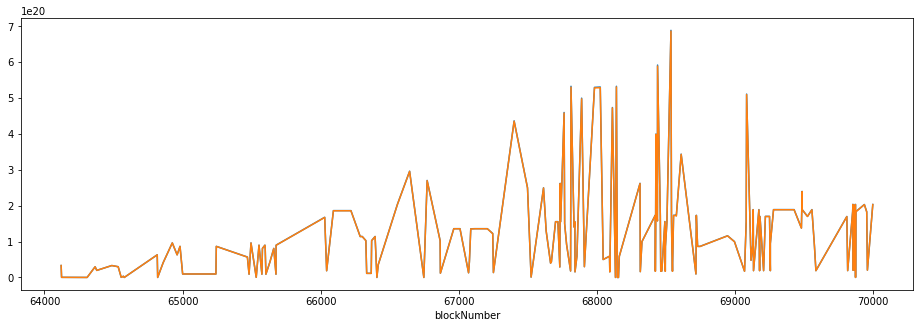

In [17]:
(df_exchange['sellamount']).plot()
(df_exchange['buyamount']).plot()

exchanger     2
buyamount     2
sellamount    2
soldgold      2
dtype: int64


exchanger     175
buyamount     175
sellamount    175
soldgold      175
dtype: int64

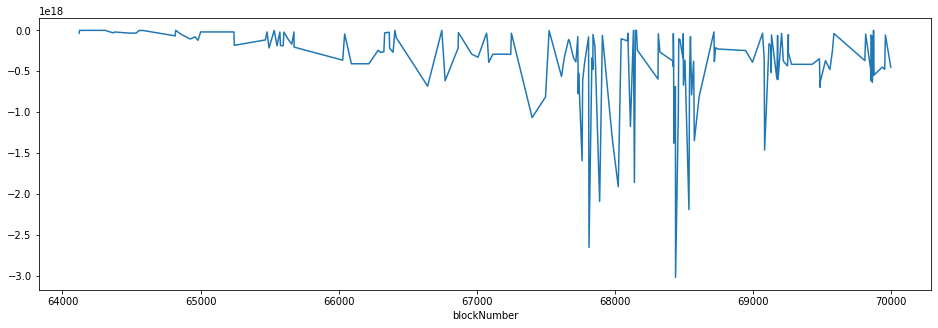

In [18]:
# difference
(df_exchange['buyamount']-df_exchange['sellamount']).plot()
print(df_exchange[df_exchange.soldgold].count())
df_exchange[df_exchange.soldgold == False].count()


In [19]:
df_ex = df_events.set_index('blockNumber')[['buyamount', 'sellamount', 'currentStableBucket', 'currentGoldBucket', 'soldgold']]
df_ex = df_ex[df_ex.buyamount.notna()]

Text(0, 0.5, 'currentGoldBucket')

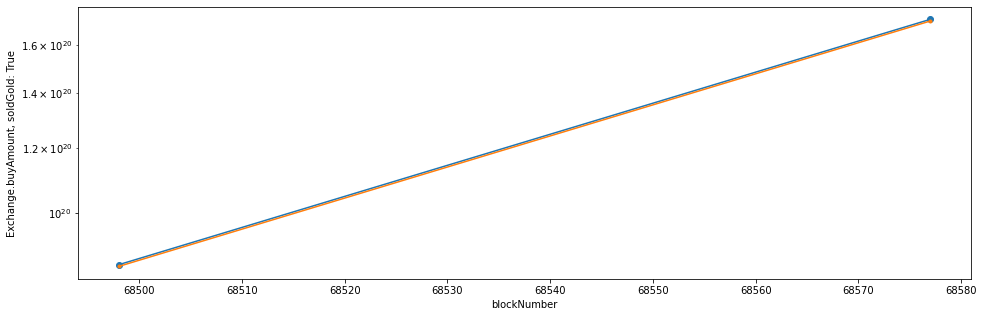

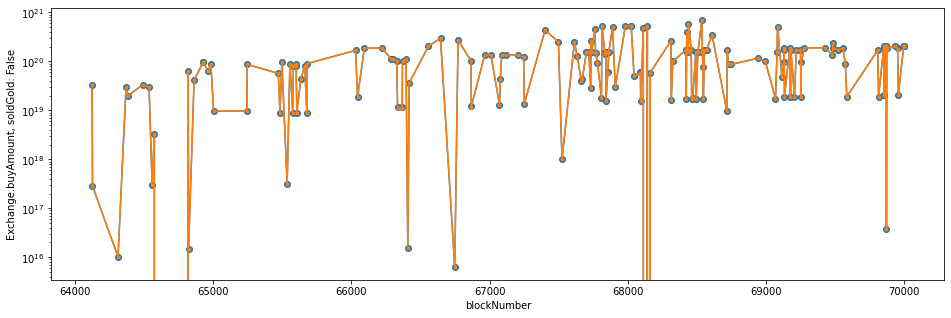

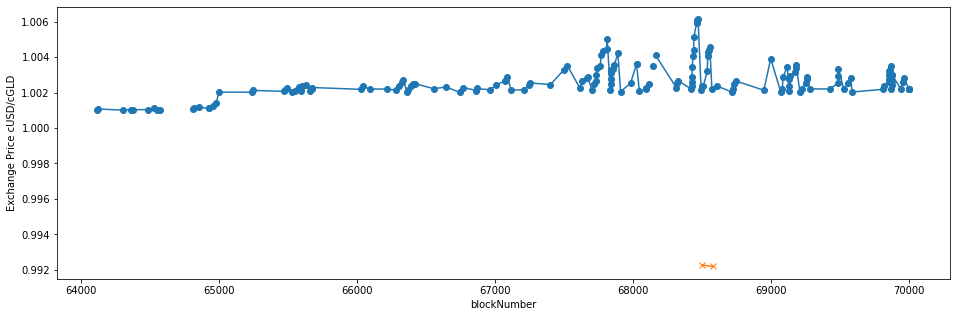

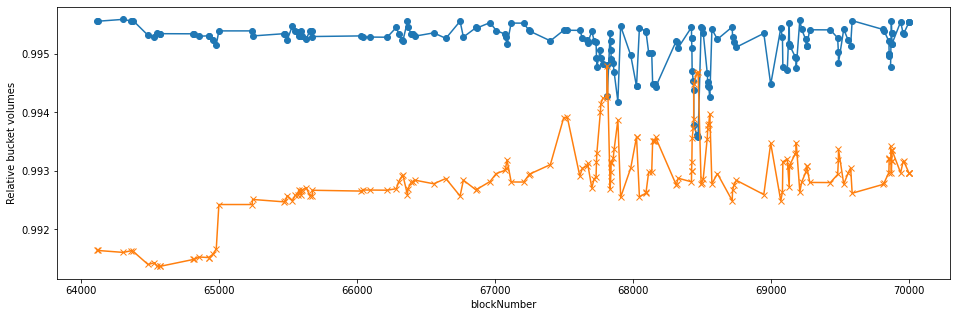

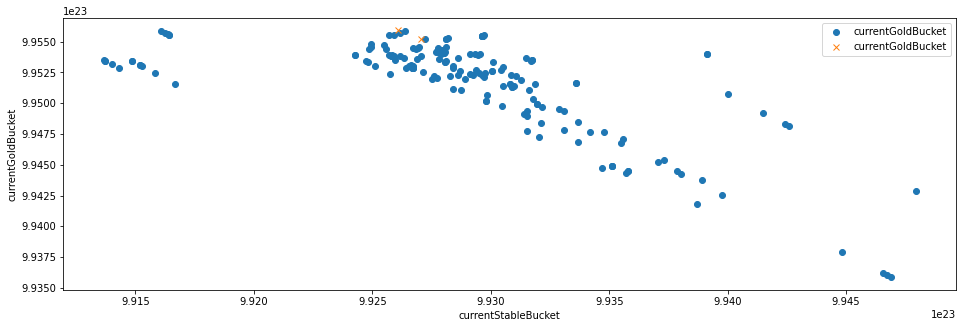

In [20]:
def estimate_buyamount(soldGold):
    df_buy = df_ex[df_ex.soldgold == soldGold]
    Ab = df_buy.buyamount
    As = df_buy.sellamount
    Bs = df_buy.currentStableBucket
    Bg = df_buy.currentGoldBucket
    Bbuy = Bs if soldGold else Bg
    Bsell = Bg if soldGold else Bs

    # buyamount computation is
    # Asell = (1-spread)*As
    # Abuy = Asell/(Bsell+Asell)*Bbuy
    spread = 0
    Asell = (1-spread)*As
    Abuy_hat = Asell/(Bsell+Asell)*Bbuy
    # Abuy_hat = Asell/(Bsell)*Bbuy
    
    return df_buy, Abuy_hat, Bbuy, Bsell


soldGold = True
df_buy_sellgold, Abuy_hat_sellgold, Bbuy_sellgold, Bsell_sellgold = estimate_buyamount(soldGold)
ax = Abuy_hat_sellgold.plot(marker='o')
ax.set_ylabel(f"Exchange.buyAmount, soldGold: {soldGold}")
df_buy_sellgold.buyamount.plot(marker='.')
(df_buy_sellgold.buyamount - Abuy_hat_sellgold).plot(marker='x', logy=True)

soldGold = False
df_buy_sellusd, Abuy_hat_sellusd, Bbuy_sellusd, Bsell_sellusd = estimate_buyamount(False)
plt.figure()
ax = Abuy_hat_sellusd.plot(marker='o')
ax.set_ylabel(f"Exchange.buyAmount, soldGold: {soldGold}")
df_buy_sellusd.buyamount.plot(marker='.')
(df_buy_sellusd.buyamount - Abuy_hat_sellusd).plot(marker='x', logy=True)

plt.figure()
ax = (df_buy_sellusd.sellamount/df_buy_sellusd.buyamount).plot(marker='o')
(df_buy_sellgold.buyamount/df_buy_sellgold.sellamount).plot(marker='x')
ax.set_ylabel(f"Exchange Price cUSD/cGLD")

plt.figure()
ax = (df_buy_sellusd.currentGoldBucket/1e24).plot(marker='o')
(df_buy_sellusd.currentStableBucket/1e24).plot(marker='x')
ax.set_ylabel(f"Relative bucket volumes")

fig, ax = plt.subplots(1, 1)
df_buy_sellusd.plot(x='currentStableBucket', y='currentGoldBucket', style='o', ax=ax)
df_buy_sellgold.plot(x='currentStableBucket', y='currentGoldBucket', style='x', ax=ax)
ax.set_ylabel(f"currentGoldBucket")

In [21]:
df_goldlocked = df_events[df_events.eventName == "GoldLocked"].set_index('blockNumber')[['account', 'value']]
df_goldlocked[['value']] = df_goldlocked[['value']].astype('float')
df_goldlocked.groupby('account').value.sum().sort_values(ascending=False)
df_goldlocked[df_goldlocked.account == "0x775a5C899Fd4A7CDD54e9f41738087748CfcB953"].groupby('account').value.sum().sort_values(ascending=False)

Series([], Name: value, dtype: float64)

In [22]:
df_receipt.head()

,blockNumber,from,address,topic
0,70000.0,0xc563f264f98e34a409c6a085da7510de8b6fe90b,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...
1,70000.0,0xc563f264f98e34a409c6a085da7510de8b6fe90b,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0x000000000000000000000000c563f264f98e34a409c6...
2,70000.0,0xc563f264f98e34a409c6a085da7510de8b6fe90b,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0x000000000000000000000000c6d678fc6cc1da9d5ed1...
3,70000.0,0x66a3fc7e8fd6932568cdb6610f5a67bed9f5bef8,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...
4,70000.0,0x66a3fc7e8fd6932568cdb6610f5a67bed9f5bef8,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,0x00000000000000000000000066a3fc7e8fd6932568cd...


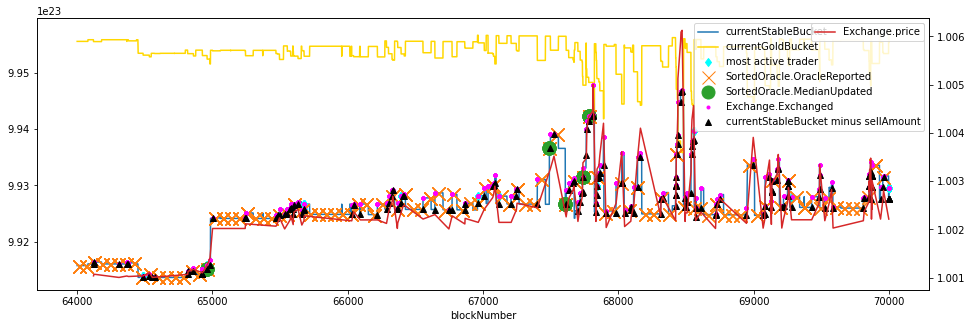

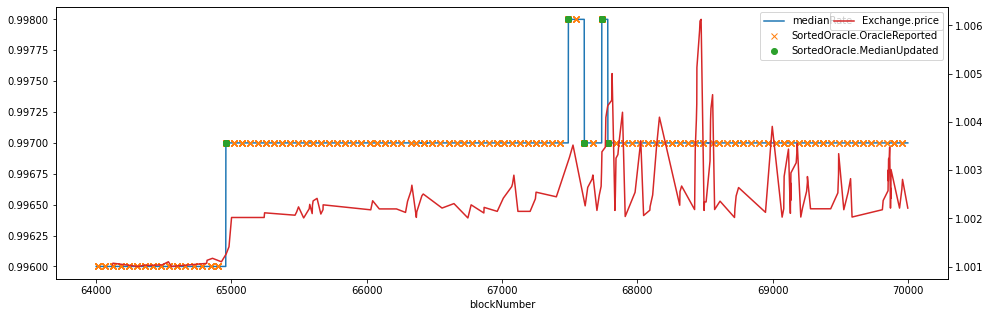

In [23]:
SortedOraclesAddress = '0x91061bF2F509AF76aa01F46E9F3E97577a5a80BA'
OracleReported = '0xdbf09271932e018b9c31e9988e4fbe3109fdd79d78f5d19a764dfb56035ed775'
MedianUpdated = '0x01f3db74cdcb3b158f2144fb78c5ab54e9e8a8c09d3d3b7713050cdb6b6bcb97'
Exchange = '0xC8FD77490A12F46709BffbCC0FCe35740Da8D860'
Exchanged = '0x402ac9185b4616422c2794bf5b118bfcc68ed496d52c0d9841dfa114fdeb05ba'

def filter_event(_df, event, arg='topic'):
    df_event_matches = _df[_df[arg] == event]
    return df_event_matches \
        .merge(df_events, left_on='blockNumber', right_on='blockNumber', suffixes=('_receipt', '')) \
        .merge(df_state, left_on='blockNumber', right_on='blockNumber', suffixes=('', '_state'))

df_report = filter_event(df_receipt, OracleReported)
df_median = filter_event(df_receipt, MedianUpdated)
df_exchanged = filter_event(df_receipt, Exchanged)

df_price = df_buy_sellusd[df_buy_sellusd.index>=window_min]
df_price = df_price[df_price.index<=window_max]
df_price = df_price[df_price.sellamount>0]
price_exchange = df_price.sellamount/df_price.buyamount

df_exchangers = df_exchanged.groupby('from_receipt').count().sort_values(by='blockNumber', ascending=False)
top_exchanger = df_exchangers.index[0] if len(df_exchangers.index) else None

df_active_trader = filter_event(df_receipt, top_exchanger, 'from')
df_active_trader = df_active_trader[df_active_trader.sellamount>0]
fig, ax = plt.subplots()
df_state.set_index('blockNumber').currentStableBucket.plot(ax=ax)
df_state.set_index('blockNumber').currentGoldBucket.plot(ax=ax, marker=".", ms=0, color='gold')
df_active_trader.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="d", linestyle='None', label="most active trader", color="cyan")
df_report.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="x", ms=13, linestyle='None', label="SortedOracle.OracleReported")
df_median.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="o", ms=13, linestyle='None', label="SortedOracle.MedianUpdated")
df_exchanged.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker=".", linestyle='None', label="Exchange.Exchanged", color="magenta")
df_volumes = df_exchanged.set_index('blockNumber')
df_volumes = df_volumes[df_volumes.sellamount>0]
(df_volumes.currentStableBucket - df_volumes.sellamount).plot(ax=ax, marker="^", linestyle='None', color="black", label="currentStableBucket minus sellAmount")
price_exchange.plot(ax=ax, secondary_y=True, label='Exchange.price')
[ax.legend(loc=1) for ax in plt.gcf().axes]

fig, ax = plt.subplots()
df_state.set_index('blockNumber').medianRate.plot(ax=ax)
df_report.set_index('blockNumber').medianRate.plot(ax=ax, marker="x", linestyle='None', label="SortedOracle.OracleReported")
df_median.set_index('blockNumber').medianRate.plot(ax=ax, marker="o", linestyle='None', label="SortedOracle.MedianUpdated")
price_exchange.plot(ax=ax, secondary_y=True, label='Exchange.price')
[ax.legend(loc=1) for ax in plt.gcf().axes]

In [24]:
df_exchangers.head()

,blockNumber,address_receipt,topic,address,eventName,identifier,addr,identifierhash,slasheridentifier,account,...,medianRate_state,currentStableBucket_state,currentGoldBucket_state,goldTokenTotalSupply_state,timestamp_block_state,gasUsed_state,gasLimit_state,txAmount_state,blocktime_state,datetime_block_state
from_receipt,,,,,,,,,,,,,,,,,,,,,
0xcccd3999d5b421f906c4a35c0c95bcd533e1cfbb,259,259,259,259,259,0,0,0,0,1,...,259,259,259,259,259,259,259,259,259,259
0x1dbe73b0480058106798adda62e25d5279233c1b,137,137,137,137,137,0,0,0,0,2,...,137,137,137,137,137,137,137,137,137,137
0x96b473b7a71f1a3804ad306af4f07f86c796eff5,106,106,106,106,106,0,0,0,0,2,...,106,106,106,106,106,106,106,106,106,106
0xd99bedef76c9caa7ec0cfdaa79c1b9330bb02061,104,104,104,104,104,0,0,0,0,2,...,104,104,104,104,104,104,104,104,104,104
0xc9d9a8dbbc238ce17134dc9c12447dcc137630a7,94,94,94,94,94,0,0,0,0,2,...,94,94,94,94,94,94,94,94,94,94


/home/dimi/celo/celo-monorepo/packages/transaction-metrics-exporter/venv/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


blockNumber
64080.0   NaN
64181.0   NaN
64369.0   NaN
64439.0   NaN
64548.0   NaN
           ..
69587.0   NaN
69646.0   NaN
69867.0   NaN
69932.0   NaN
69999.0   NaN
Length: 65, dtype: float64

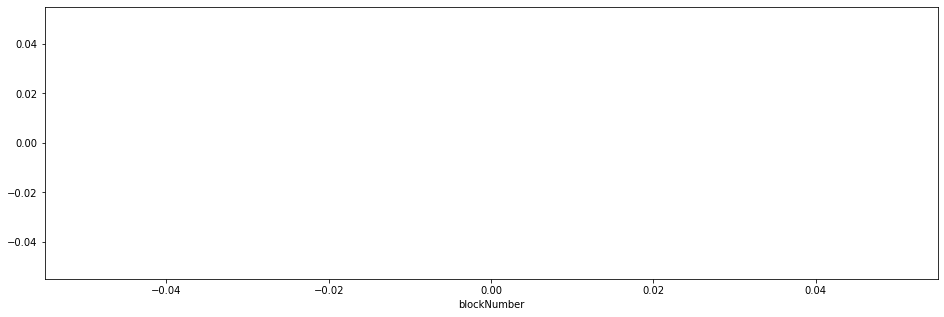

In [25]:
r = df_state.set_index('blockNumber').currentGoldBucket.diff()
exchange_balance = (0.01*(df_balance[df_balance.contract=="GoldToken"].set_index('blockNumber').balance))
bucket_diff = (df_state.set_index('blockNumber').currentGoldBucket - exchange_balance)

fig, ax = plt.subplots()
bucket_diff.plot(ax=ax)
bucket_diff[bucket_diff.abs()<1e10].plot(ax=ax, marker='s', linestyle='None')
bucket_diff[bucket_diff!=0].plot(ax=ax, marker='.', linestyle='None')
bucket_diff[r>0].plot(ax=ax, marker='o', linestyle='None')
bucket_diff[r<0].plot(ax=ax, marker='^', linestyle='None')
bucket_diff[r>0]

[]

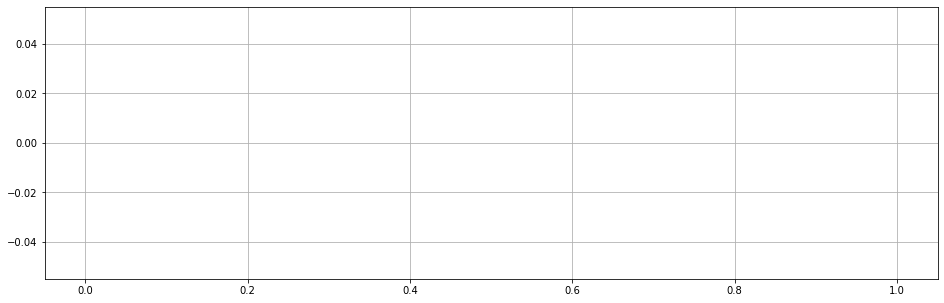

In [26]:
bucket_diff.hist().plot()